# Description

**The dataset is available at : https://www.kaggle.com/datamunge/sign-language-mnist/home**

**The Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).**

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). **The training data (27,455 cases) and test data (7172 cases)** are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2....pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

This dataset was inspired by the Fashion-MNIST 2 and the machine learning pipeline for gestures by Sreehari 4.

A robust visual recognition algorithm could provide not only new benchmarks that challenge modern machine learning methods such as Convolutional Neural Nets but also could pragmatically help the deaf and hard-of-hearing better communicate using computer vision applications. The National Institute on Deafness and other Communications Disorders (NIDCD) indicates that the 200-year-old American Sign Language is a complete, complex language (of which letter gestures are only part) but is the primary language for many deaf North Americans. ASL is the leading minority language in the U.S. after the "big four": Spanish, Italian, German, and French. One could implement computer vision in an inexpensive board computer like Raspberry Pi with OpenCV, and some Text-to-Speech to enabling improved and automated translation applications.

## Load Modules

In [32]:
# !pip install tensorflow==2.0.0-rc0    # To install tensorflow 2.0 version 
# !pip install --upgrade numpy  # To upgrade numpy to latest version
import tensorflow as tf
import numpy as np
import pandas as pd

print(tf.__version__)
print(np.__version__)
print(pd.__version__)

1.14.0
1.16.5
0.24.2


## Load Training and Test Dataset from respective *.csv file

In [33]:
train_dataset = pd.read_csv('sign_mnist_train.csv')
print('Trainframe Shape:', train_dataset.shape)

test_dataset = pd.read_csv('sign_mnist_test.csv')
print('Testframe Shape:', test_dataset.shape)

train_dataset.head()
# print(train_dataset.head())
# print(test_dataset.head())

Trainframe Shape: (27455, 785)
Testframe Shape: (7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


## Convert Image Dimension & Change Label to One Hot Encoding

In [34]:
# We need to seperate the input images(x) and output label(y). So, below code lines pop out the labels from train and test dataset
y_train = train_dataset.pop('label')
y_test = test_dataset.pop('label')
print(y_train.shape)
# print(y_test.shape)
print(train_dataset.shape)

# Copy the train and test dataset that is left only with image pixels into new variables
x_train = train_dataset.copy()
x_test = test_dataset.copy()

# Split the training input dataset into training and validation dataset with 10% allocated for validation
# and 90% allocated for training
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.1)

# Convert the data into float
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# Normalize the image data by converting every pixel that ranges from 0-255 to 0 to 1 
x_train /= 255
x_val  /= 255
x_test /= 255

# Reshape the 784 pixel images into 28x28x1 
x_train = np.array(x_train).reshape(x_train.shape[0],28,28,1)
x_val = np.array(x_val).reshape(x_val.shape[0],28,28,1)
x_test = np.array(x_test).reshape(x_test.shape[0],28,28,1)
print(x_train.shape)
print(x_train[1].shape)
print(x_val[1].shape)
print(x_test[1].shape)

INPUT_SHAPE = x_train[1].shape # to be used during training of model

# Converts a class vector (integers) to binary class matrix. This is required to use `categorical_crossentropy` Cost Function
# One Hot encoding of Lables
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(27455,)
(27455, 784)
(24709, 28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(24709, 25)
(2746, 25)
(7172, 25)


## Display Random Images from training Dataset

Figure(432x288)


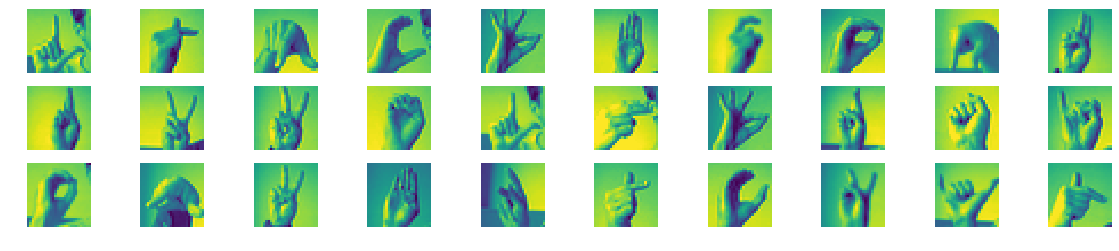

In [35]:
import matplotlib.pyplot as plt

fig = plt.gcf()                  # (G)et (C)urrent (F)igure dimension in pixels
print(fig)
fig.set_size_inches(20, 4)      # set the total figure size in inches

for i in range(30):
  sp = plt.subplot(3, 10, i+1)  # display subplots having maximum of 4 rows and 4 columns
  sp.axis('Off')               # Don't show axis (or gridlines)
  random_number = np.random.randint(15000)
  plt.imshow(x_train[random_number].reshape(28,28))

## Define and Compile The Model

In [36]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the Model
model = tf.keras.models.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(25, activation='softmax'))

# Prints Model Summary of created Layers
model.summary()

# Compile the model
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_5 (Dense)              (None, 25)               

## Alternate way to Define & Compile the Model
**The code in the above cell can be made in this way also**

In [0]:
# from tensorflow.keras.optimizers import Adam

# # Define the Model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(25, activation='softmax')])

# # Prints Model Summary of created Layers
# model.summary()

# # Compile the model
# model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


## Train the Model

In [37]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64, verbose=1)

Train on 24709 samples, validate on 2746 samples
Epoch 1/10
24709/24709 [==============================] - 4s 177us/sample - loss: 1.3059 - acc: 0.6158 - val_loss: 0.2948 - val_acc: 0.9228
Epoch 2/10
24709/24709 [==============================] - 4s 170us/sample - loss: 0.1396 - acc: 0.9660 - val_loss: 0.0562 - val_acc: 0.9876
Epoch 3/10
24709/24709 [==============================] - 4s 168us/sample - loss: 0.0234 - acc: 0.9981 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 4/10
24709/24709 [==============================] - 4s 170us/sample - loss: 0.0077 - acc: 0.9998 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 5/10
24709/24709 [==============================] - 4s 171us/sample - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 6/10
24709/24709 [==============================] - 4s 169us/sample - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 0.9993
Epoch 7/10
24709/24709 [==============================] - 4s 169us/sample - loss: 0.0010 - acc: 1.0000 - val_lo

## Evaluate the Model on Test Dataset

In [38]:
model.evaluate(x_test,y_test)

7172/7172 [==============================] - 1s 115us/sample - loss: 0.4327 - acc: 0.9147


[0.4326717581999126, 0.91466814]

## Plot Perfomance Graph

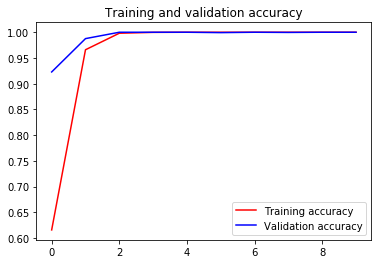

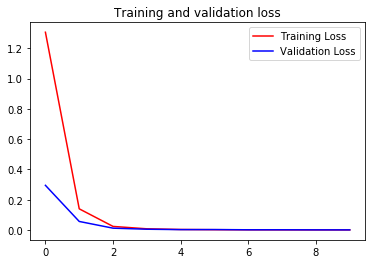

In [39]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()